<a href="https://colab.research.google.com/github/unicamp-dl/IA025_2022S1/blob/main/ex04/Marcus_Vinicius_Borela_de_Castro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook de referência 

Nome: Marcus Vinicius Borela de Castro

# Regressão Softmax com dados do MNIST utilizando gradiente descendente estocástico por minibatches

Este exercicío consiste em treinar um modelo de uma única camada linear no MNIST **sem** usar as seguintes funções do pytorch:

- torch.nn.Linear
- torch.nn.CrossEntropyLoss
- torch.nn.NLLLoss
- torch.nn.LogSoftmax
- torch.optim.SGD
- torch.utils.data.Dataloader

## Importação das bibliotecas

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torchvision
from torchvision.datasets import MNIST

In [2]:
import math

## Fixando as seeds

In [3]:
def inicializa_seed(num_semente:int=123):
  """
  É recomendado reiniciar as seeds antes de inicializar o modelo, pois assim
  garantimos que os pesos vao ser sempre os mesmos.
  fontes de apoio: 
      http://nlp.seas.harvard.edu/2018/04/03/attention.html
      https://github.com/CyberZHG/torch-multi-head-attention/blob/master/torch_multi_head_attention/multi_head_attention.py#L15
  """
  random.seed(num_semente)
  np.random.seed(num_semente)
  torch.manual_seed(num_semente)
  #torch.cuda.manual_seed(num_semente)
  #Cuda algorithms
  #torch.backends.cudnn.deterministic = True 

In [4]:
inicializa_seed(123)

## Dataset e dataloader

### Definição do tamanho do minibatch

In [5]:
batch_size = 50

### Carregamento, criação dataset e do dataloader

In [6]:
dataset_dir = '../data/'

dataset_train_full = MNIST(dataset_dir, train=True, download=True,
                           transform=torchvision.transforms.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [7]:
print(f"dataset_train_full.data.shape: {dataset_train_full.data.shape}")
print(f"dataset_train_full.targets.shape: {dataset_train_full.targets.shape}")

dataset_train_full.data.shape: torch.Size([60000, 28, 28])
dataset_train_full.targets.shape: torch.Size([60000])


### Usando apenas 1000 amostras do MNIST

Neste exercício utilizaremos 1000 amostras de treinamento.

In [8]:
indices = torch.randperm(len(dataset_train_full))[:1000]
dataset_train = torch.utils.data.Subset(dataset_train_full, indices)

In [9]:
len(indices), indices[:10], indices[-10:]

(1000,
 tensor([12382, 10826, 20070, 40629, 44540, 35142, 35700, 47452, 27771, 56203]),
 tensor([31785, 13673, 19403, 13490, 10607, 48755, 58183,  2763, 14662, 30383]))

In [10]:
type(dataset_train)

torch.utils.data.dataset.Subset

In [11]:
dataset_train.dataset.data.shape

torch.Size([60000, 28, 28])

In [12]:
dataset_train.indices[:10]

tensor([12382, 10826, 20070, 40629, 44540, 35142, 35700, 47452, 27771, 56203])

In [13]:
dataset_train.dataset.data[12382].shape

torch.Size([28, 28])

In [14]:
tuple(dataset_train.dataset.data[12382].shape)

(28, 28)

In [15]:
tuple(dataset_train.dataset.data[12382].shape)[0]

28

In [16]:
dataset_train.dataset.data[12382][:2,:]

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]], dtype=torch.uint8)

In [17]:
dataset_train.dataset.targets.shape, dataset_train.dataset.targets[12382]

(torch.Size([60000]), tensor(1))

In [18]:
dataset_train.indices[10:15]

tensor([11341, 48038, 52806, 29207, 27788])

In [19]:
print(len(dataset_train))

1000


In [20]:
dataset_train[0][1]

1

In [21]:
dataset_train[0][0].shape

torch.Size([1, 28, 28])

In [22]:
dataset_train[0][0][0][:2,:]

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.]])

In [23]:
data, label = dataset_train[0]

In [24]:
data.shape, label

(torch.Size([1, 28, 28]), 1)

In [25]:
type(data)

torch.Tensor

In [26]:
# Escreva aqui o equivalente do código abaixo:
# loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=False)

In [27]:
class MeuDataLoader():

  def __init__(self, subdataset:torch.utils.data.dataset.Subset, batch_size:int=batch_size, shuffle:bool=False, verbose:bool=False):
    self.subdataset = subdataset
    self.batch_size = batch_size
    self.shuffle = shuffle
    self.verbose = verbose
    self.posicao_leitura = 0
    self.tamanho = math.ceil(len(dataset_train)/self.batch_size)
    self.image_size = tuple(self.subdataset.dataset.data[0].shape)
    if self.verbose:
      print(f"Inicializado MeuDataLoader batch_size: {self.batch_size} shuffle: {self.shuffle}  image_size: {self.image_size} tamanho: {self.tamanho} ")

  def __iter__(self):
      self.posicao_leitura = 0
      return self

  def __next__(self):
    # peguei dica em https://discuss.pytorch.org/t/batch-sample-from-the-dataset/42461/2 
    if self.verbose: print(f" next self.posicao_leitura: {self.posicao_leitura} self.posicao_leitura+self.batch_size: {self.posicao_leitura + self.batch_size} self.tamanho*self.batch_size: {self.tamanho *  self.batch_size}")
    if (self.posicao_leitura + self.batch_size) > (self.tamanho *  self.batch_size):
      raise StopIteration()
    batch_labels = torch.empty((self.batch_size, 1), dtype=int)    
    batch_data = torch.empty((self.batch_size, self.image_size[0], self.image_size[1]), requires_grad=True)
    if self.verbose:
      print(f"proximos {self.batch_size} a partir de {self.posicao_leitura}")
      print(f"batch_labels.shape = {batch_labels.shape}")
      print(f"batch_data.shape = {batch_data.shape}")
    batch_labels = None
    batch_data = None      
    for i, data_idx in enumerate(range(self.posicao_leitura, self.posicao_leitura + self.batch_size)):
      if self.verbose and i in (0, batch_size-1):
        print(f"for - i:{i} data_idx:{data_idx}")
      data, label = self.subdataset[data_idx]
      if i == 0:
        batch_data = data
        batch_labels = torch.tensor([label])
      else:      
        batch_data = torch.cat((batch_data, data))
        batch_labels = torch.cat((batch_labels, torch.tensor([label])))
      # batch_data[i] = data
      # batch_labels[i] = label
    self.posicao_leitura += self.batch_size
    if self.verbose: print(f" final next self.posicao_leitura: {self.posicao_leitura}")
    
    return batch_data, batch_labels

  def __len__(self):
    return self.tamanho

In [28]:
loader_train = MeuDataLoader(dataset_train, batch_size=batch_size, shuffle=False, verbose=True)


Inicializado MeuDataLoader batch_size: 50 shuffle: False  image_size: (28, 28) tamanho: 20 


In [29]:
print('Número de minibatches de trenamento:', len(loader_train))


Número de minibatches de trenamento: 20


In [30]:
x_train, y_train = next(iter(loader_train))

 next self.posicao_leitura: 0 self.posicao_leitura+self.batch_size: 50 self.tamanho*self.batch_size: 1000
proximos 50 a partir de 0
batch_labels.shape = torch.Size([50, 1])
batch_data.shape = torch.Size([50, 28, 28])
for - i:0 data_idx:0
for - i:49 data_idx:49
 final next self.posicao_leitura: 50


In [31]:
print(f"\nDimensões dos dados de um minibatch: x_train.size() {x_train.size()} y_train.size() {y_train.size()} ")
print("Valores mínimo e máximo dos pixels: ", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:         ", type(x_train))
print("Tipo das classes das imagens:       ", type(y_train))


Dimensões dos dados de um minibatch: x_train.size() torch.Size([50, 28, 28]) y_train.size() torch.Size([50]) 
Valores mínimo e máximo dos pixels:  tensor(0.) tensor(1.)
Tipo dos dados das imagens:          <class 'torch.Tensor'>
Tipo das classes das imagens:        <class 'torch.Tensor'>


In [32]:
for tt in y_train:
  print(tt.item())
  break

1


## Modelo

In [33]:
# Escreva aqui o codigo para criar um modelo cujo o equivalente é: 
# model = torch.nn.Linear(28*28, 10)
# model.load_state_dict(dict(weight=torch.zeros(model.weight.shape), bias=torch.zeros(model.bias.shape)))

In [34]:
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  if torch.cuda.is_available(): print(torch. cuda. get_device_name(device))  

In [35]:
class MeuLinear(): 
  def __init__(self, num_entrada:int, num_saida:int):
    # inicializando com zeros
    # como em model.load_state_dict(dict(weight=torch.zeros(model.weight.shape), bias=torch.zeros(model.bias.shape)))
    # super().__init__()
    self.pesos = torch.zeros((num_entrada, num_saida), requires_grad=True) # .to(device)
    self.bias = torch.zeros((1, num_saida), requires_grad=True) # .to(device)
    #torch.nn.init.kaiming_uniform_(self.pesos, a=math.sqrt(5))
    #torch.nn.init.kaiming_uniform_(self.bias, a=math.sqrt(5))
  
  def __call__(self, entrada:torch.Tensor):
    return torch.mm(entrada, self.pesos) + self.bias  
  
  def parameters(self)->list:
    return [self.pesos, self.bias]

## Treinamento

## Definição da Loss



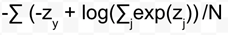

In [36]:
class MinhaCrossEntropyLoss():
  """
  Exemplos
   classes_reais: y_train: tensor([[1],[3],[1],...])
   logitos_classes_previstas: tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                                      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                                      (...)
                                      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], grad_fn=<AddBackward0>)                                     
  """
  def __init__(self, verbose:bool=False):
    self.verbose = verbose

  def __call__(self, logitos_classes_previstas:torch.Tensor, classes_reais:torch.Tensor):
    assert logitos_classes_previstas.shape[0] == classes_reais.shape[0], f"Número de registros (dimensão 0) não batem logitos_classes_previstas.shape: {logitos_classes_previstas.shape} e classes_reais.shape: {classes_reais.shape} "  
    #calculo de softmax por amostra
    # softmax_sobre_logitos_classes_previstas_por_amostra = f.softmax(logitos_classes_previstas,1)
    #calculo de exp(z) 
    exp_logitos = torch.exp(logitos_classes_previstas)
    if self.verbose: print(f"exp_logitos[:3]: {exp_logitos[:3]}")
    soma_exp_logitos = exp_logitos.sum(dim=1)
    if self.verbose: print(f"soma_exp_logitos[:3]: {soma_exp_logitos[:3]}")
    log_soma_exp_logitos = torch.log(soma_exp_logitos)
    if self.verbose: print(f"log_soma_exp_logitos[:3]: {log_soma_exp_logitos[:3]} log_soma_exp_logitos.shape: {log_soma_exp_logitos.shape}")

    logito_classe_prevista = logitos_classes_previstas.gather(dim=1, index= classes_reais.unsqueeze(dim=1))
    logito_classe_prevista = logito_classe_prevista.squeeze(dim=1)
    if self.verbose: print(f"logito_classe_prevista[:3]: {logito_classe_prevista[:3]} logito_classe_prevista.shape: {logito_classe_prevista.shape}")


    loss_por_amostra = -logito_classe_prevista + log_soma_exp_logitos
    if self.verbose: print(f"loss_por_amostra[:3]: {loss_por_amostra[:3]} loss_por_amostra.shape: {loss_por_amostra.shape}")

    loss = torch.mean(loss_por_amostra)
    if self.verbose: print(f"loss: {loss}  loss.shape: {loss.shape}")

    return loss

# Definição do Optimizer

In [37]:
# Escreva aqui o equivalente de:
# optimizer = torch.optim.SGD(model.parameters(), lr)

class MeuOtimizadorSGD():
  def __init__(self, lista_parametros:list, lr:float, verbose:bool=False):
    self.lista_parametros=lista_parametros
    self.lr = lr
    self.verbose = verbose
    print(f"iniciando MeuOtimizadorSGD self.lr {self.lr} self.lista_parametros:{self.lista_parametros} ")

  def step(self):
    for parameter in self.lista_parametros:
      if self.verbose: print(f":: step - antes parameter.data.sum(): {parameter.data.sum()}, parameter.grad.sum(): {parameter.grad.sum()}")
      parameter.data = parameter.data - self.lr * parameter.grad
      if self.verbose: print(f":: step - depois parameter.data.sum(): {parameter.data.sum()}, parameter.grad.sum(): {parameter.grad.sum()}")
  
  def zero_grad(self):
    for parameter in self.lista_parametros:
      # if self.verbose: print(f"parameter: {parameter}, parameter.grad.sum(): {parameter.grad.sum()} :: zero_grad")
      parameter.grad = torch.zeros_like(parameter.data)

### Laço de treinamento dos parâmetros

### Inicialização dos parâmetros

In [38]:
model = MeuLinear(28*28,10)


In [39]:
loader_train = MeuDataLoader(dataset_train, batch_size=batch_size, shuffle=False, verbose=False)

In [40]:
criterion = MinhaCrossEntropyLoss(verbose=False)
# criterion = CrossEntropyLoss()

In [41]:
n_epochs = 50
lr = 0.1

In [42]:
optimizer = MeuOtimizadorSGD(model.parameters(), lr, verbose=False)


iniciando MeuOtimizadorSGD self.lr 0.1 self.lista_parametros:[tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], requires_grad=True), tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], requires_grad=True)] 


In [43]:
epochs = []
loss_history = []
loss_epoch_end = []
total_trained_samples = 0

In [44]:
for i in range(n_epochs):
    # Substitua aqui o loader_train de acordo com sua implementação do dataloader.
    for ndx, (x_train, y_train) in enumerate(loader_train):
        # Transforma a entrada para uma dimensão 
        # De   torch.Size([50, 28, 28])
        # para torch.Size([50, 784])

        # x = x_train.to(device)
        # y = y_train.to(device)
        inputs = x_train.view(-1, 28 * 28)
        
        # predict da rede
        outputs = model(inputs)
        # print(f"\nndx {ndx} outputs[:3] previstos: {outputs[:3]}")
        # print(f"y_train[:3]: {y_train[:3]}")
        
        # calcula a perda
        loss = criterion(outputs, y_train)
        # print(f"loss: {loss}")
        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        # Escreva aqui o código cujo o resultado é equivalente às 3 linhas abaixo:
        # zera os gradientes do passo anterior
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_trained_samples += x_train.size(0)
        epochs.append(total_trained_samples / len(dataset_train))
        loss_history.append(loss.item())
    loss_epoch_end.append(loss.item())
    print(f'Epoch: {i:d}/{n_epochs - 1:d} Loss: {loss.item()}')


Epoch: 0/49 Loss: 1.1979684829711914
Epoch: 1/49 Loss: 0.867622971534729
Epoch: 2/49 Loss: 0.7226786613464355
Epoch: 3/49 Loss: 0.6381281018257141
Epoch: 4/49 Loss: 0.5809750556945801
Epoch: 5/49 Loss: 0.5387411713600159
Epoch: 6/49 Loss: 0.5056463479995728
Epoch: 7/49 Loss: 0.47862708568573
Epoch: 8/49 Loss: 0.4558936655521393
Epoch: 9/49 Loss: 0.4363219141960144
Epoch: 10/49 Loss: 0.4191650152206421
Epoch: 11/49 Loss: 0.403904527425766
Epoch: 12/49 Loss: 0.39016804099082947
Epoch: 13/49 Loss: 0.3776799738407135
Epoch: 14/49 Loss: 0.3662315011024475
Epoch: 15/49 Loss: 0.35566142201423645
Epoch: 16/49 Loss: 0.34584280848503113
Epoch: 17/49 Loss: 0.33667415380477905
Epoch: 18/49 Loss: 0.3280735909938812
Epoch: 19/49 Loss: 0.31997358798980713
Epoch: 20/49 Loss: 0.3123184144496918
Epoch: 21/49 Loss: 0.30506110191345215
Epoch: 22/49 Loss: 0.2981624901294708
Epoch: 23/49 Loss: 0.29158854484558105
Epoch: 24/49 Loss: 0.2853103280067444
Epoch: 25/49 Loss: 0.27930304408073425
Epoch: 26/49 Loss:

### Visualizando gráfico de perda durante o treinamento

Text(0.5, 0, 'época')

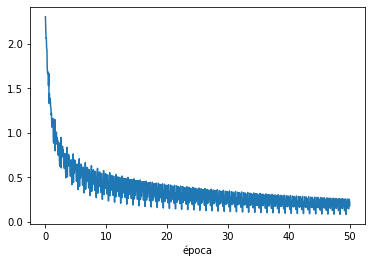

In [45]:
plt.plot(epochs, loss_history)
plt.xlabel('época')

### Visualização usual da perda, somente no final de cada minibatch

Text(0.5, 0, 'época')

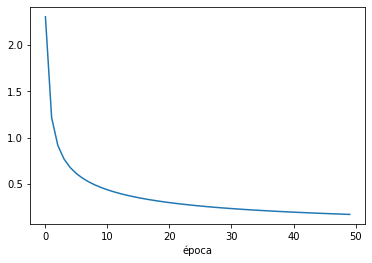

In [46]:
n_batches_train = len(loader_train)
plt.plot(epochs[::n_batches_train], loss_history[::n_batches_train])
plt.xlabel('época')

In [47]:
# Assert do histórico de losses
target_loss_epoch_end = np.array([
    1.1979684829711914,
    0.867622971534729,
    0.7226786613464355,
    0.6381281018257141,
    0.5809749960899353,
    0.5387411713600159,
    0.5056464076042175,
    0.4786270558834076,
    0.4558936357498169,
    0.4363219141960144,
    0.4191650450229645,
    0.4039044976234436,
    0.3901679515838623,
    0.3776799440383911,
    0.3662314713001251,
    0.35566139221191406,
    0.34584277868270874,
    0.33667415380477905,
    0.32807353138923645,
    0.31997355818748474,
    0.312318354845047,
    0.3050611615180969,
    0.29816246032714844,
    0.29158851504325867,
    0.28531041741371155,
    0.2793029546737671,
    0.273544579744339,
    0.2680158317089081,
    0.26270008087158203,
    0.2575823664665222,
    0.25264936685562134,
    0.24788929522037506,
    0.24329163134098053,
    0.23884665966033936,
    0.23454584181308746,
    0.23038141429424286,
    0.22634628415107727,
    0.22243399918079376,
    0.2186385989189148,
    0.21495483815670013,
    0.21137762069702148,
    0.20790249109268188,
    0.20452524721622467,
    0.20124195516109467,
    0.19804897904396057,
    0.1949428766965866,
    0.19192075729370117,
    0.188979372382164,
    0.18611609935760498,
    0.1833282858133316])

assert np.allclose(np.array(loss_epoch_end), target_loss_epoch_end, atol=1e-6)

## Exercício 

Escreva um código que responda às seguintes perguntas:

Qual é a amostra classificada corretamente, com maior probabilidade?

Qual é a amostra classificada erradamente, com maior probabilidade?

Qual é a amostra classificada corretamente, com menor probabilidade?

Qual é a amostra classificada erradamente, com menor probabilidade?

In [48]:
from torch.nn import functional as f

In [49]:
class AnaliseAmostra():
  def __init__(self, logitos_classes_previstas, classes_reais, verbose:bool=False):
    self.verbose = verbose
    num_classes = logitos_classes_previstas.shape[-1]
    num_amostras = logitos_classes_previstas.shape[0]
    classes_reais_onehot = torch.eye(num_classes)[classes_reais] #.to(device)
    #calculo de softmax por amostra
    softmax_sobre_logitos_classes_previstas_por_amostra = f.softmax(logitos_classes_previstas,1)
    if self.verbose: print(f"classes_reais[:3]: {classes_reais[:3]}")
    if self.verbose: print(f"classes_reais_onehot[:3]: {classes_reais_onehot[:3]}")
    if self.verbose: print(f"softmax_sobre_logitos_classes_previstas_por_amostra[:3]: {softmax_sobre_logitos_classes_previstas_por_amostra[:3]}")
    (prob_classe_prevista, classe_prevista) = torch.topk(softmax_sobre_logitos_classes_previstas_por_amostra, 1)
    # remover última dimensão: passar de [num_amostras, 1] para [num_amostras]
    prob_classe_prevista = prob_classe_prevista.squeeze()
    classe_prevista = classe_prevista.squeeze()    
    if self.verbose: print(f"prob_classe_prevista[:3]: {prob_classe_prevista[:3]}")
    if self.verbose: print(f"classe_prevista[:3]: {classe_prevista[:3]}")
    acertou = classe_prevista == classes_reais
    if self.verbose: print(f"acertou[:3]: {acertou[:3]}")
    self.prob_acertos = torch.mul(acertou, prob_classe_prevista)
    if self.verbose: print(f"self.prob_acertos[:3]: {self.prob_acertos[:3]}")
    self.prob_erros = torch.mul(~acertou, prob_classe_prevista)
    if self.verbose: print(f"self.prob_erros[:3]: {self.prob_erros[:3]}")

  def corretas_com_mais_certeza(self, qtd_amostra:int):
    """
    Retorna as amostras corretas com mais certeza 
       (maior probabilidade)
    """
    (_, amostras) = torch.topk(self.prob_acertos, k=qtd_amostra, largest=True)
    return amostras

  def corretas_com_menos_certeza(self, qtd_amostra:int):
    """
    Retorna as amostras corretas com menos certeza 
       (menor probabilidade)
    """
    (_, amostras) = torch.topk(self.prob_acertos, k=qtd_amostra, largest=False)
    return amostras

  def incorretas_com_mais_certeza(self, qtd_amostra:int):
    """
    Retorna as amostras incorretas com mais certeza 
       (maior probabilidade)
    """
    (_, amostras) = torch.topk(self.prob_erros, k=qtd_amostra, largest=True)
    return amostras

  def incorretas_com_menos_certeza(self, qtd_amostra:int):
    """
    Retorna as amostras incorretas com menos certeza 
       (menor probabilidade)
    """
    (_, amostras) = torch.topk(self.prob_erros, k=qtd_amostra, largest=False)
    return amostras


In [50]:
dataset_dir = '../data/'

dataset_test_full = MNIST(dataset_dir, train=False, download=True,
                           transform=torchvision.transforms.ToTensor())

In [51]:
print(f"dataset_test_full.data.shape: {dataset_test_full.data.shape}")
print(f"dataset_test_full.targets.shape: {dataset_test_full.targets.shape}")

dataset_test_full.data.shape: torch.Size([10000, 28, 28])
dataset_test_full.targets.shape: torch.Size([10000])


In [52]:
indices_test = torch.randperm(len(dataset_test_full))[:1000]
dataset_test = torch.utils.data.Subset(dataset_test_full, indices_test)

In [53]:
loader_test= MeuDataLoader(dataset_test, batch_size=1000, shuffle=False, verbose=False)

In [54]:
x_test, y_test = next(iter(loader_test))


In [55]:
y_predicted = model(x_test.view(-1, 28 * 28))

In [56]:
analises = AnaliseAmostra(y_predicted, y_test, True)

classes_reais[:3]: tensor([9, 0, 7])
classes_reais_onehot[:3]: tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])
softmax_sobre_logitos_classes_previstas_por_amostra[:3]: tensor([[2.7218e-03, 7.6495e-03, 5.5742e-04, 1.0260e-01, 1.7772e-02, 7.0427e-02,
         1.0841e-03, 1.1627e-01, 2.0709e-01, 4.7384e-01],
        [5.3346e-01, 4.2376e-05, 9.9750e-03, 2.5265e-03, 1.3514e-03, 4.2603e-01,
         2.2578e-02, 1.3803e-03, 7.4441e-04, 1.9094e-03],
        [6.9601e-04, 1.2862e-04, 4.7398e-04, 3.3232e-04, 8.4474e-04, 4.0461e-03,
         6.3532e-05, 8.4637e-01, 6.0794e-04, 1.4644e-01]],
       grad_fn=<SliceBackward0>)
prob_classe_prevista[:3]: tensor([0.4738, 0.5335, 0.8464], grad_fn=<SliceBackward0>)
classe_prevista[:3]: tensor([9, 0, 7])
acertou[:3]: tensor([True, True, True])
self.prob_acertos[:3]: tensor([0.4738, 0.5335, 0.8464], grad_fn=<SliceBackward0>)
self.prob_erros[:3]: tensor([0.,

In [57]:
analises.corretas_com_mais_certeza(10)

tensor([177, 381, 337, 356, 179, 350, 210, 124, 615, 339])

In [58]:
incorretas_com_mais_certeza = analises.incorretas_com_mais_certeza(10)
incorretas_com_mais_certeza

tensor([ 59, 275, 605, 628, 885,  68, 568, 946, 769, 985])

## Exercício Bonus

Implemente um dataloader que aceite como parâmetro de entrada a distribuição probabilidade das classes que deverão compor um batch.
Por exemplo, se a distribuição de probabilidade passada como entrada for:

`[0.01, 0.01, 0.72, 0.2, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]`

Em média, 72% dos exemplos do batch deverão ser da classe 2, 20% deverão ser da classe 3, e os demais deverão ser das outras classes.

Mostre também que sua implementação está correta.


Trabalhando com os 60 mil registros

In [62]:
print(f"dataset_train_full.data.shape: {dataset_train_full.data.shape}")
print(f"dataset_train_full.targets.shape: {dataset_train_full.targets.shape}")

dataset_train_full.data.shape: torch.Size([60000, 28, 28])
dataset_train_full.targets.shape: torch.Size([60000])


In [63]:
dataset_train_full.targets[:10]

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4])

In [64]:
dataset_train_full.data[:2]

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)

In [65]:
dataset_train_full

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data/
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
num_amostras = len(dataset_train_full.data); num_amostras

60000

In [ ]:
weights = torch.tensor([0.01, 0.01, 0.72, 0.2, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01])
weights

tensor([0.0100, 0.0100, 0.7200, 0.2000, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100])

### Experimentações

Experimentando orch.distributions.categorical.Categorical

In [96]:
from torch.distributions.categorical import Categorical

In [102]:
distribuicao = Categorical(probs=weights, logits=None, validate_args=None)

In [104]:
batch_amostras = distribuicao.sample_n(100)

/usr/local/lib/python3.7/dist-packages/torch/distributions/distribution.py:159: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


In [111]:
output, inverse_indices, counts = torch.unique(
batch_amostras, sorted=True, return_inverse=True, return_counts=True)

In [113]:
output, inverse_indices, counts/100

(tensor([0, 1, 2, 3, 4, 5, 7, 8, 9]),
 tensor([3, 2, 2, 2, 7, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 3, 2,
         2, 2, 2, 2, 3, 3, 2, 2, 8, 2, 3, 2, 0, 2, 2, 2, 1, 3, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 3, 2, 2, 3, 1, 6, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3,
         3, 2, 2, 3, 5, 3, 2, 2, 5, 3, 2, 2, 2, 2, 3, 2, 3, 3, 1, 4, 2, 2, 2, 1,
         3, 2, 2, 3]),
 tensor([0.0100, 0.0400, 0.6600, 0.2300, 0.0100, 0.0200, 0.0100, 0.0100, 0.0100]))

Experimentando torch.multinomial

In [115]:
dist = torch.multinomial(weights, 100, replacement=True)

In [116]:
output, inverse_indices, counts = torch.unique(
dist, sorted=True, return_inverse=True, return_counts=True)

In [117]:
output, inverse_indices, counts/100

(tensor([0, 1, 2, 3, 5, 6, 7, 8]),
 tensor([3, 3, 2, 3, 2, 2, 3, 2, 0, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 3, 2,
         6, 5, 3, 0, 2, 3, 2, 1, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2,
         2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 3, 2, 3, 3, 3, 2, 7, 2, 2, 2, 2, 2,
         2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 0, 3, 2, 3, 2, 2, 2, 2,
         2, 2, 2, 5]),
 tensor([0.0300, 0.0200, 0.7000, 0.2000, 0.0100, 0.0200, 0.0100, 0.0100]))

Experimentando WeightedRandomSampler

In [59]:
from torch.utils.data import WeightedRandomSampler

In [71]:
list(WeightedRandomSampler(weights, 5, replacement=True))

[2, 2, 2, 2, 2]

In [91]:
 indices_num_classe = np.array(list(WeightedRandomSampler(weights, 100, replacement=True)))

In [92]:
indices_num_classe[:10]

array([3, 3, 1, 3, 2, 1, 2, 2, 2, 1])

### Definição da classe

In [ ]:
class MeuImbalancedDataLoader():

  def __init__(self, subdataset:torch.utils.data.dataset.Subset, weights:torch.Tensor, batch_size:int=batch_size,  shuffle:bool=False, verbose:bool=False):
    """
      São 10 classes (dígitos). Seus valores em labels vão de 0 a 9.
      
      Definir array com números entre 1 e num_classes conforme probabilidade passada no array weights - indices_num_classe.
      De forma que a cada num_batches sejam considerados os pesos
      Exemplo:
        [0,1,3,4,4,4,5,9,6,9,...] cujo tamanho é o número de amostras

      O tamanho do batch deve ser tal que o número de elementos da classe com menor probabilidade tenha pelo menos 1 elemento.

      Inicializar indice_proxima_amostra = 0 (próxima posição a ser lida em indices_num_classe)
      
      Criar um dicionário ultimo_lido_num_classe (keys= números das classes) com ponteiro para último lido. Inicializar com -1.
      Exemplo:
        [0, -1, -1, 3, -1, 5, -1, 2, -1, 1, 10] cujo tamanho é o número de classes
    """
    self.weights = weights
    assert len(weights)==1, "weights deve ser um tensor com apenas uma dimensão"
    self.num_classes = self.weights.size[0] 
    ###  parei aqui

  def __next__(self):
    """
    Pegar próximos tamanho_batch:
      Se não conseguir gerar por falta em alguma classe, gerar exception: StopIteration()

      Concatenar tamanho_batch:
        definir a proxima_classe (indices_num_classe[indice_proxima_amostra])
        obter das amostras a próxima amostra da proxima_classe
          definir proximo_indice_amostra como sendo o índice em y superior a ultimo_lido_num_classe[proxima_classe] cujo valor seja proxima_classe
          Se não conseguir: gerar exception: StopIteration()
          pegar em x o registro de índice proximo_indice_amostra
        concatenar até alcançar tamanho_bach
    """

  def __iter__(self):
    """
     Inicializar dicionário ultimo_lido_num_classe (keys= números das classes) com ponteiro para último lido == -1.
    """
  def __len__(self):
    """
    """

## Rascunhos 

### Analise das amostras

In [ ]:
logitos_classes_previstas = y_predicted
classes_reais = y_test

In [ ]:
    num_classes = logitos_classes_previstas.shape[-1]
    num_amostras = logitos_classes_previstas.shape[0]
    classes_reais_onehot = torch.eye(num_classes)[classes_reais] #.to(device)
    #calculo de softmax por amostra
    softmax_sobre_logitos_classes_previstas_por_amostra = f.softmax(logitos_classes_previstas,1)
    # probabilidade_previsao = torch.mul(softmax_sobre_logitos_classes_previstas_por_amostra, classes_reais_onehot)
    print(f"classes_reais[:3]: {classes_reais[:3]}")
    print(f"classes_reais_onehot[:3]: {classes_reais_onehot[:3]}")
    print(f"softmax_sobre_logitos_classes_previstas_por_amostra[:3]: {softmax_sobre_logitos_classes_previstas_por_amostra[:3]}")
    # print(f"probabilidade_previsao[:3]: {probabilidade_previsao[:3]}
    # (probabilidade_previsao, )   torch.topk(probabilidade_previsao, 1)
    (probabilidade_previsao, classe_prevista) = torch.topk(softmax_sobre_logitos_classes_previstas_por_amostra, 1)
# remover última dimensão: passar de [num_amostras, 1] para [num_amostras]
    prob_classe_prevista = prob_classe_prevista.squeeze()
    classe_prevista = classe_prevista.squeeze()    
    print(f"prob_classe_prevista[:3]: {prob_classe_prevista[:3]}")
    print(f"classe_prevista[:3]: {classe_prevista[:3]}")
    acertou = classe_prevista == classes_reais
    print(f"acertou[:3]: {acertou[:3]}")
    prob_acertos = torch.mul(acertou, prob_classe_prevista)
    print(f"prob_acertos[:3]: {prob_acertos[:3]}")
    prob_erros = torch.mul(~acertou, prob_classe_prevista)
    print(f"prob_erros[:3]: {prob_erros[:3]}")


classes_reais[:3]: tensor([3, 3, 3])
classes_reais_onehot[:3]: tensor([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])
softmax_sobre_logitos_classes_previstas_por_amostra[:3]: tensor([[3.8546e-06, 3.0551e-03, 1.6681e-03, 3.3064e-03, 8.2782e-01, 1.2521e-03,
         1.8511e-03, 1.1929e-01, 3.9415e-03, 3.7813e-02],
        [1.3891e-04, 3.2202e-05, 2.2989e-02, 9.3894e-01, 2.3499e-04, 1.0469e-03,
         1.2225e-04, 1.8290e-06, 3.6385e-02, 1.0459e-04],
        [1.5378e-03, 2.5596e-04, 1.1215e-01, 8.3060e-01, 8.3326e-05, 1.9912e-02,
         3.5956e-04, 5.0905e-04, 3.4504e-02, 9.4141e-05]],
       grad_fn=<SliceBackward0>)


In [ ]:
(_, amostras) = torch.topk(prob_acertos, k=20, largest=True)

In [ ]:
amostras

tensor([458,  80, 579,  75, 348, 347, 575, 430, 589, 391, 206, 934, 892, 364,
        864, 716, 968, 807,  27, 886])

In [ ]:
prob_acertos[458]

tensor(1.0000, grad_fn=<SelectBackward0>)

In [ ]:
(_, amostras_corretas_menos_certas) = torch.topk(prob_acertos, k=20, largest=False)

In [ ]:
amostras_corretas_menos_certas

tensor([607, 868, 201, 737, 405, 736, 205, 423, 182, 727, 185, 177, 722, 885,
        172, 433, 893, 905, 157, 402])

In [ ]:
prob_acertos[402]

tensor(0., grad_fn=<SelectBackward0>)

In [ ]:
acertou.shape, prob_classe_prevista.shape

(torch.Size([1000]), torch.Size([1000]))

In [ ]:
# remover última dimensão: passar de [num_amostras, 1] para [num_amostras]
prob_classe_prevista = prob_classe_prevista.squeeze()
classe_prevista = classe_prevista.squeeze()

In [ ]:
prob_classe_prevista.shape

torch.Size([1000, 1])

### crossentropy a partir dos logitos

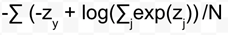

In [ ]:
logitos_classes_previstas = y_predicted
classes_reais = y_test
print(f"logitos_classes_previstas[:3]: {logitos_classes_previstas[:3]} logitos_classes_previstas.shape: {logitos_classes_previstas.shape}")
print(f"classes_reais[:3]: {classes_reais[:3]} classes_reais.shape: {classes_reais.shape}")

logitos_classes_previstas[:3]: tensor([[-2.0532, -1.0199, -3.6390,  1.5763, -0.1769,  1.2001, -2.9737,  1.7014,
          2.2786,  3.1064],
        [ 4.6302, -4.8104,  0.6509, -0.7223, -1.3480,  4.4053,  1.4678, -1.3268,
         -1.9443, -1.0024],
        [-0.9065, -2.5950, -1.2907, -1.6458, -0.7128,  0.8536, -3.3003,  6.1968,
         -1.0418,  4.4425]], grad_fn=<SliceBackward0>) logitos_classes_previstas.shape: torch.Size([1000, 10])
classes_reais[:3]: tensor([9, 0, 7]) classes_reais.shape: torch.Size([1000])


In [ ]:
num_classes = logitos_classes_previstas.shape[-1]
classes_reais_onehot = torch.eye(num_classes)[classes_reais] #.to(device)

#calculo de softmax por amostra
# softmax_sobre_logitos_classes_previstas_por_amostra = f.softmax(logitos_classes_previstas,1)
#calculo de exp(z) 
exp_logitos = torch.exp(logitos_classes_previstas)
print(f"exp_logitos[:3]: {exp_logitos[:3]}")
soma_exp_logitos = exp_logitos.sum(dim=1)
print(f"soma_exp_logitos[:3]: {soma_exp_logitos[:3]}")
log_soma_exp_logitos = torch.log(soma_exp_logitos)
print(f"log_soma_exp_logitos[:3]: {log_soma_exp_logitos[:3]} log_soma_exp_logitos.shape: {log_soma_exp_logitos.shape}")


exp_logitos[:3]: tensor([[1.2832e-01, 3.6064e-01, 2.6280e-02, 4.8369e+00, 8.3788e-01, 3.3203e+00,
         5.1113e-02, 5.4814e+00, 9.7632e+00, 2.2339e+01],
        [1.0254e+02, 8.1450e-03, 1.9173e+00, 4.8562e-01, 2.5975e-01, 8.1886e+01,
         4.3397e+00, 2.6531e-01, 1.4308e-01, 3.6701e-01],
        [4.0393e-01, 7.4646e-02, 2.7508e-01, 1.9287e-01, 4.9025e-01, 2.3481e+00,
         3.6871e-02, 4.9119e+02, 3.5282e-01, 8.4987e+01]],
       grad_fn=<SliceBackward0>)
soma_exp_logitos[:3]: tensor([ 47.1454, 192.2078, 580.3519], grad_fn=<SliceBackward0>)
log_soma_exp_logitos[:3]: tensor([3.8532, 5.2586, 6.3636], grad_fn=<SliceBackward0>) log_soma_exp_logitos.shape: torch.Size([1000])


In [ ]:
logitos_classes_previstas[0:2].gather(dim=1, index= torch.Tensor([[3],[2]]).long())

In [ ]:
classes_reais.unsqueeze(dim=1)[:3]

tensor([[9],
        [0],
        [7]])

In [ ]:
logitos_classes_previstas[0:2].gather(dim=1, index= classes_reais.unsqueeze(dim=1)[:2])

tensor([[3.1064],
        [4.6302]], grad_fn=<GatherBackward0>)

In [ ]:
logito_classe_prevista = logitos_classes_previstas.gather(dim=1, index= classes_reais.unsqueeze(dim=1))
logito_classe_prevista = logito_classe_prevista.squeeze(dim=1)
print(f"logito_classe_prevista[:3]: {logito_classe_prevista[:3]} logito_classe_prevista.shape: {logito_classe_prevista.shape}")

logito_classe_prevista[:3]: tensor([3.1064, 4.6302, 6.1968], grad_fn=<SliceBackward0>) logito_classe_prevista.shape: torch.Size([1000])


In [ ]:
loss_por_amostra = logito_classe_prevista + log_soma_exp_logitos
print(f"loss_por_amostra[:3]: {loss_por_amostra[:3]} loss_por_amostra.shape: {loss_por_amostra.shape}")


loss_por_amostra[:3]: tensor([ 6.9596,  9.8888, 12.5605], grad_fn=<SliceBackward0>) loss_por_amostra.shape: torch.Size([1000])


In [ ]:
loss = torch.mean(loss_por_amostra)
print(f"loss: {loss}  loss.shape: {loss.shape}")


loss: 13.048205375671387  loss.shape: torch.Size([])


In [ ]:
logitos_classes_previstas[0], logitos_classes_previstas[1], logitos_classes_previstas[0:2]

(tensor([-2.0532, -1.0199, -3.6390,  1.5763, -0.1769,  1.2001, -2.9737,  1.7014,
          2.2786,  3.1064], grad_fn=<SelectBackward0>),
 tensor([ 4.6302, -4.8104,  0.6509, -0.7223, -1.3480,  4.4053,  1.4678, -1.3268,
         -1.9443, -1.0024], grad_fn=<SelectBackward0>),
 tensor([[-2.0532, -1.0199, -3.6390,  1.5763, -0.1769,  1.2001, -2.9737,  1.7014,
           2.2786,  3.1064],
         [ 4.6302, -4.8104,  0.6509, -0.7223, -1.3480,  4.4053,  1.4678, -1.3268,
          -1.9443, -1.0024]], grad_fn=<SliceBackward0>))

In [ ]:
logitos_classes_previstas[0,3]

tensor(1.5763, grad_fn=<SelectBackward0>)

In [ ]:
logitos_classes_previstas[0:2,[3,2]]

tensor([[ 1.5763, -3.6390],
        [-0.7223,  0.6509]], grad_fn=<IndexBackward0>)

In [ ]:
logitos_classes_previstas[0:2,[[3],[2]]]

tensor([[[ 1.5763],
         [-3.6390]],

        [[-0.7223],
         [ 0.6509]]], grad_fn=<IndexBackward0>)

In [ ]:
logitos_classes_previstas[0:2].gather(dim=1, index= torch.Tensor([[3],[2]]).long())

tensor([[1.5763],
        [0.6509]], grad_fn=<GatherBackward0>)

In [ ]:
logitos_classes_previstas[0:2].gather(dim=1, index= torch.Tensor([3, 2]).long())

RuntimeError: ignored

### outros

In [ ]:
outputs.shape[1]

10

In [ ]:
outputs.shape

torch.Size([50, 10])

In [ ]:
y_train[:3]

tensor([6, 8, 7])

In [ ]:
torch.eye(outputs.shape[-1])[y]

tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],


In [ ]:
outputs[:4]

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [ ]:
y_train[:3]

tensor([6, 8, 7])

In [ ]:
t = torch.tensor([[0., 1., 2., 3., 0., 0., 0., 0., 0., 0.],[0., 1., 2., 3., 0., 0., 0., 0., 0., 0.]])

In [ ]:
x_train.shape

torch.Size([50, 28, 28])

In [ ]:
x_train.view(-1, 28 * 28).shape

torch.Size([50, 784])

In [ ]:
t[0][2]

tensor(2.)

In [ ]:
y_train[1].item()

8

## Dúvidas



Não estava aprendendo (diminuindo o custo):

   quando ponho na gpu to(device) 

   atribuindo direto para x(i) (ou usando +=)

   fórmula não matricial de custo